In [1]:
import pandas as pd

# Load imputed dataset
X_other_imputed_xgb = pd.read_csv("../data/X_other_imputed_xgb.csv")
X_test_imputed_xgb = pd.read_csv("../data/X_test_imputed_xgb.csv")

In [ ]:
import pandas as pd

# Load target variable
y_other = pd.read_csv("../data/y_other.csv").squeeze().to_numpy()
y_test = pd.read_csv("../data/y_test.csv").squeeze().to_numpy()

(3207,)
(802,)


In [18]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

def MLpipeline(X_other, y_other, X_test, y_test, ML_algo, param_grid, scoring):
    '''
    This function directly uses the provided train, validation, and test splits.
    It evaluates models using MAE, RMSE, and R², and records the best model for each metric.

    Args:
    - X_train, y_train: Training dataset
    - X_val, y_val: Validation dataset for GridSearchCV
    - X_test, y_test: Test dataset for evaluation
    - ML_algo: Machine Learning algorithm
    - param_grid: Parameter grid for hyperparameter tuning

    Returns:
    - A dictionary containing test scores (MAE, RMSE, R²)
    - The best model for each metric
    '''
    # Lists to store results
    test_scores = {
        'MAE': [],
        'RMSE': [],
        'R2': []
    }

    # GridSearchCV
    print("\nPerforming GridSearchCV...")
    grid = GridSearchCV(
        estimator=ML_algo,
        param_grid=param_grid,
        scoring=scoring,  # Single scoring metric
        refit=True,
        cv=4,  # 4-fold cross-validation
        return_train_score=True,
        n_jobs=-1,
        verbose=True
    )
    grid.fit(X_other, y_other)

    # Save the best model
    best_model = grid.best_estimator_
    validation_score = -grid.best_score_ if 'neg' in scoring else grid.best_score_
    print('Best model parameters:', grid.best_params_)
    print(f'Validation score for {scoring}:', validation_score)

    # Predictions and metrics on the test set
    y_test_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print('Test MAE:', test_mae)
    print('Test RMSE:', test_rmse)
    print('Test R²:', test_r2)

    # Store test scores
    test_scores = {
        'MAE': test_mae,
        'RMSE': test_rmse,
        'R2': test_r2
    }

    # Return results
    return test_scores, best_model, validation_score

In [13]:
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

y_mean = np.mean(y_test)  # Baseline: Predict the mean for all instances
baseline_rmse = root_mean_squared_error(y_test, [y_mean] * len(y_test))
baseline_mae = mean_absolute_error(y_test, [y_mean] * len(y_test))
baseline_r2 = r2_score(y_test, [y_mean] * len(y_test))

print("Baseline Metrics:")
print(f"Baseline RMSE: {baseline_rmse:.4f}")
print(f"Baseline MAE: {baseline_mae:.4f}")
print(f"Baseline R²: {baseline_r2:.4f}")

Baseline Metrics:
Baseline RMSE: 0.3833
Baseline MAE: 0.2889
Baseline R²: 0.0000


In [ ]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Parameter grids
param_grids = {
    'Lasso': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'Ridge': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'ElasticNet': {
        'alpha': [0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.2, 0.4, 0.6, 0.8]
    },
    'RandomForestRegressor': {
        'max_depth': [1, 3, 10, 30, 100],
        'max_features': [0.25, 0.5, 0.75, 1.0]
    },
    'KNeighborsRegressor': {
        'n_neighbors': [3, 5, 10, 20],
        'weights': ['uniform', 'distance']
    },
    'XGBRegressor': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

# Models to train
models = {
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor()
}

In [ ]:
# Initialize results dictionary and track best overall models
results = {}
best_models_overall = {
    'MAE': {'method': None, 'model': None, 'value': float('inf')},  # Lower is better
    'RMSE': {'method': None, 'model': None, 'value': float('inf')},  # Lower is better
    'R2': {'method': None, 'model': None, 'value': float('-inf')}   # Higher is better
}
scorings = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2']

# Training pipeline
for s in scorings:
    print(f"\nUsing scoring metric: {s}")
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        try:
            test_scores, best_model, validation_score = MLpipeline(
                X_other_imputed_xgb, y_other, X_test_imputed_xgb, y_test, model, param_grids[model_name], s
            )
            # Save results for each model
            results[model_name] = results.get(model_name, {})
            results[model_name][s] = {
                'Best Parameters': best_model.get_params(),
                'Validation': validation_score,
                'Test MAE': test_scores['MAE'],
                'Test RMSE': test_scores['RMSE'],
                'Test R²': test_scores['R2']
            }

            # Update best overall models for each metric
            if test_scores['MAE'] < best_models_overall['MAE']['value']:
                best_models_overall['MAE'] = {'method': model_name, 'model': best_model, 'value': test_scores['MAE']}
            if test_scores['RMSE'] < best_models_overall['RMSE']['value']:
                best_models_overall['RMSE'] = {'method': model_name, 'model': best_model, 'value': test_scores['RMSE']}
            if test_scores['R2'] > best_models_overall['R2']['value']:
                best_models_overall['R2'] = {'method': model_name, 'model': best_model, 'value': test_scores['R2']}
        except Exception as e:
            print(f"Error training {model_name} with scoring {s}: {e}")

# Print the best overall models for each metric
print("\nBest Overall Models:")
for metric, info in best_models_overall.items():
    print(f"{metric} - Method: {info['method']}, Value: {info['value']:.4f}")
    print(f"  Best Parameters: {info['model'].get_params()}\n")


Using scoring metric: neg_mean_absolute_error

Training Lasso...

Performing GridSearchCV...
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best model parameters: {'alpha': 0.01}
Validation score for neg_mean_absolute_error: 0.12842513368452407
Test MAE: 0.129476189512615
Test RMSE: 0.1972147845355382
Test R²: 0.7352044595938109

Training Ridge...

Performing GridSearchCV...
Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best model parameters: {'alpha': 1}
Validation score for neg_mean_absolute_error: 0.1066015768296514
Test MAE: 0.11100750474710881
Test RMSE: 0.17864719491602327
Test R²: 0.7827178097071597

Training ElasticNet...

Performing GridSearchCV...
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best model parameters: {'alpha': 0.01, 'l1_ratio': 0.2}
Validation score for neg_mean_absolute_error: 0.1190792523725422
Test MAE: 0.11982591739455209
Test RMSE: 0.18673270589167684
Test R²: 0.7626044855834969

Training RandomForestRegressor...


In [25]:
# Save results as a text file
with open("../results/xgb_imputed_best_models_results.txt", "w") as f:
    # Write detailed results for each model
    f.write("Detailed Results for Each Model:\n\n")
    for model_name, model_results in results.items():
        f.write(f"Model: {model_name}\n")
        for scoring_metric, metrics in model_results.items():
            f.write(f"  Scoring Metric: {scoring_metric}\n")
            f.write(f"    Best Parameters: {metrics['Best Parameters']}\n")
            f.write(f"    Validation Score: {metrics['Validation']:.4f}\n")
            f.write(f"    Test MAE: {metrics['Test MAE']:.4f}\n")
            f.write(f"    Test RMSE: {metrics['Test RMSE']:.4f}\n")
            f.write(f"    Test R²: {metrics['Test R²']:.4f}\n")
        f.write("\n")

    # Write the best overall models
    f.write("Best Overall Models:\n")
    for metric, info in best_models_overall.items():
        f.write(f"{metric} - Method: {info['method']}, Value: {info['value']:.4f}\n")
        f.write(f"  Best Parameters: {info['model'].get_params()}\n")


*Now we have the model with best performance, it's time to Interpret the model's global and local feature importances.*

In [27]:
from sklearn.inspection import permutation_importance

# Retrieve the best model (same for all three metrics)
best_model = best_models_overall['R2']['model']

# Compute permutation importance
result = permutation_importance(
    best_model, X_test_imputed_xgb, y_test, n_repeats=5, random_state=42
)

# Extract and plot top 10 feature importances
importances = result.importances_mean
sorted_indices = importances.argsort()[::-1]  # Sort in descending order

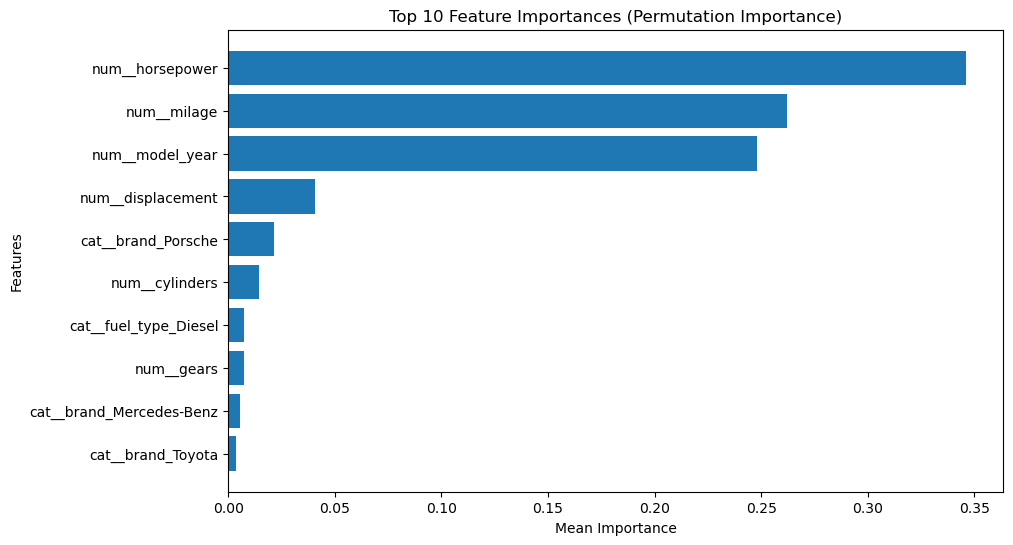

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(
    [X_test_imputed_xgb.columns[i] for i in sorted_indices[:10]],
    importances[sorted_indices[:10]],
)
plt.xlabel("Mean Importance")
plt.ylabel("Features")
plt.title("Top 10 Feature Importances (Permutation Importance)")
plt.gca().invert_yaxis()
plt.savefig('../figures/permutation_importance.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


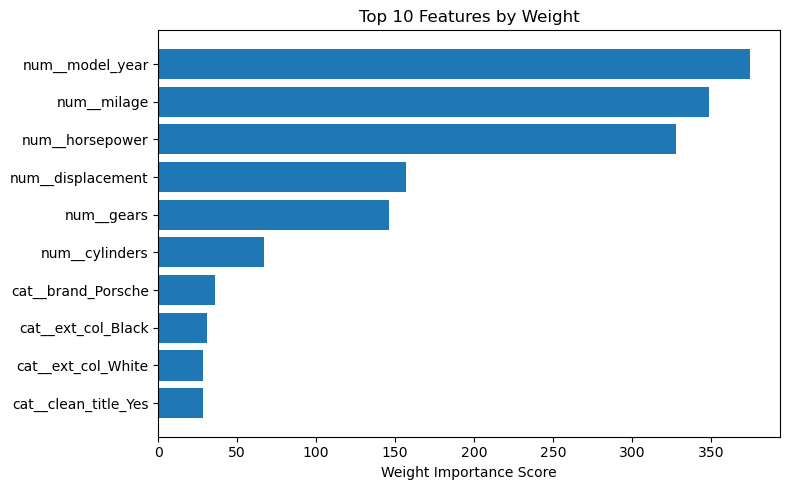

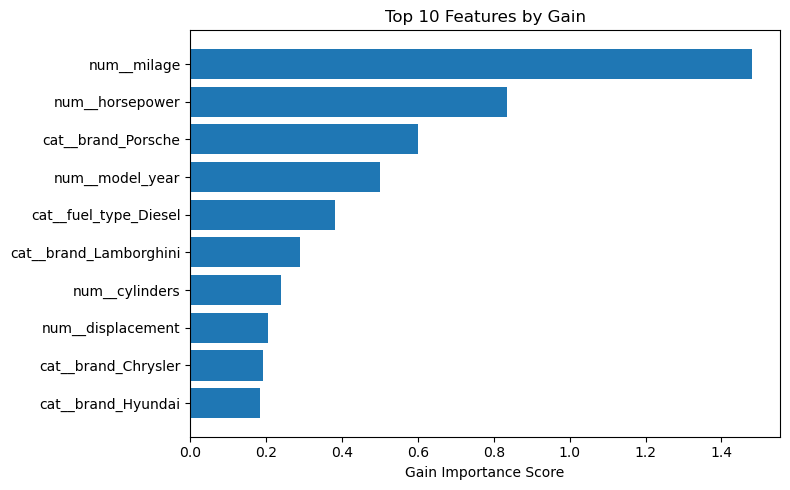

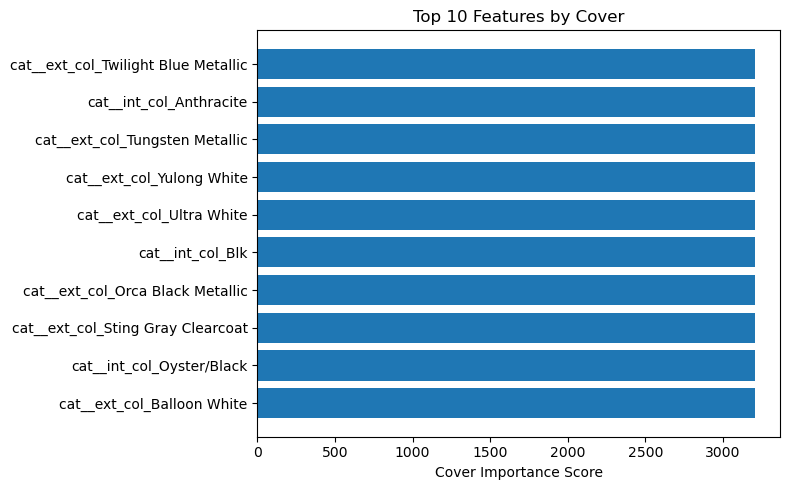

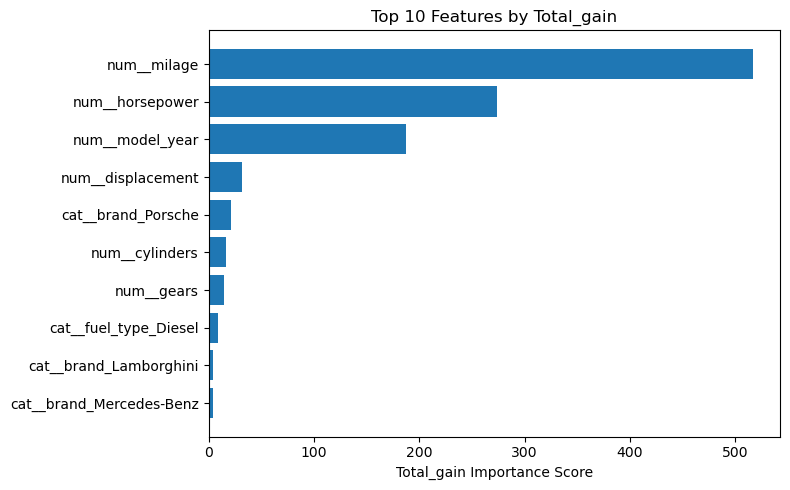

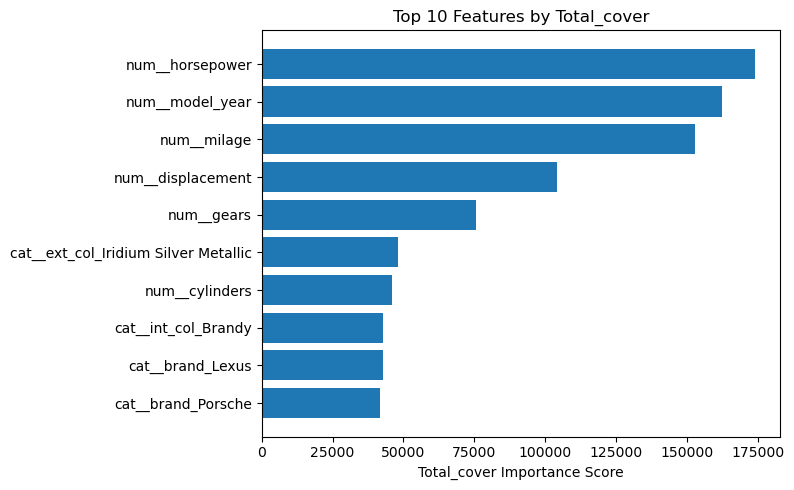

In [29]:
# Metrics to compute feature importance
booster = best_model.get_booster()
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for importance_type in importance_types:
    importance = booster.get_score(importance_type=importance_type)
    
    # Convert to a sorted list of (feature, importance)
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    
    # Take the top 10 features
    top_features = sorted_importance[:10]
    feature_names_top, importance_values_top = zip(*top_features)
    
    # Create a bar plot
    plt.figure(figsize=(8, 5))
    plt.barh(feature_names_top, importance_values_top)
    plt.title(f"Top 10 Features by {importance_type.capitalize()}")
    plt.xlabel(f"{importance_type.capitalize()} Importance Score")
    plt.gca().invert_yaxis()  
    plt.tight_layout()
    plt.savefig(f'../figures/{importance_type.capitalize()}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

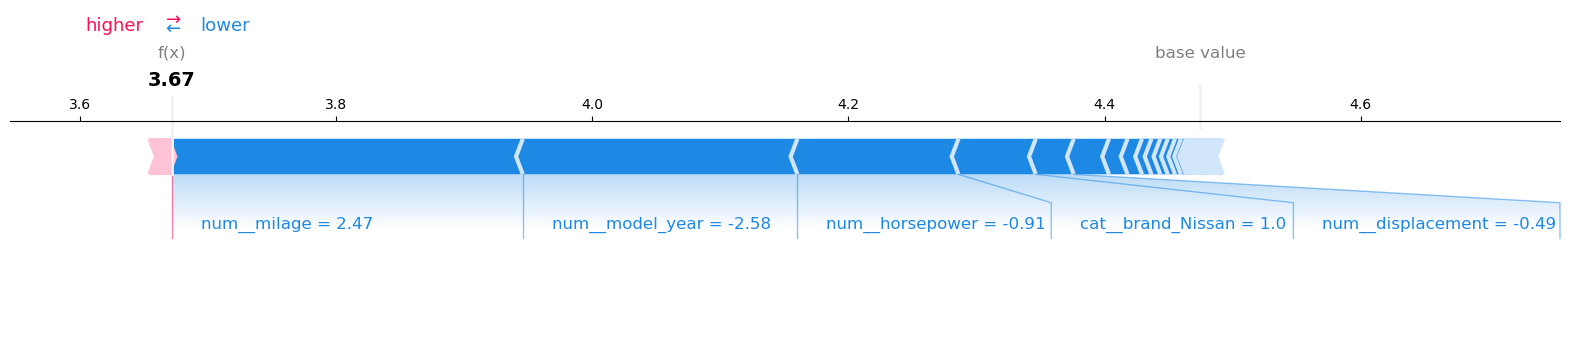

Saved SHAP force plot for index 791 to ../figures/force_plot_index_791.png


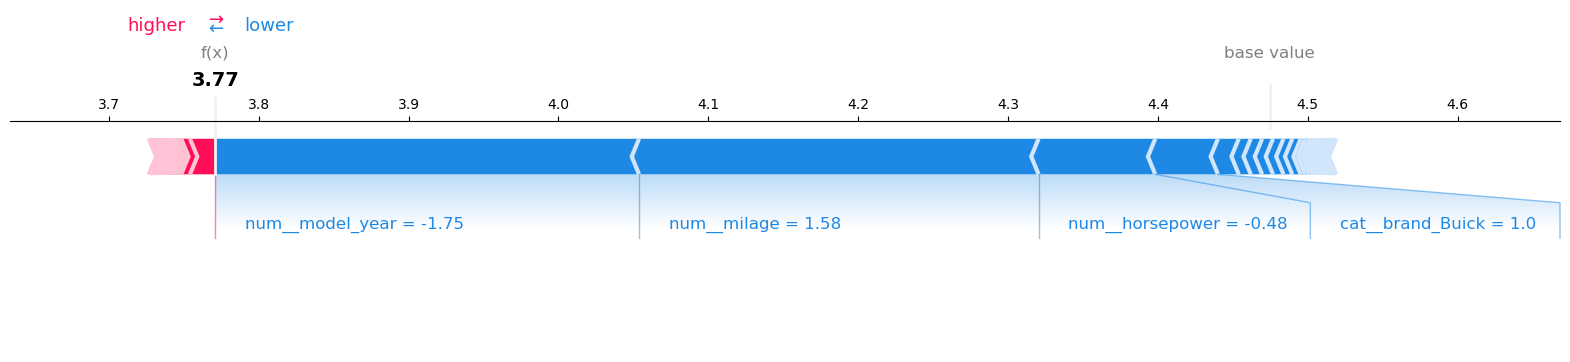

Saved SHAP force plot for index 540 to ../figures/force_plot_index_540.png


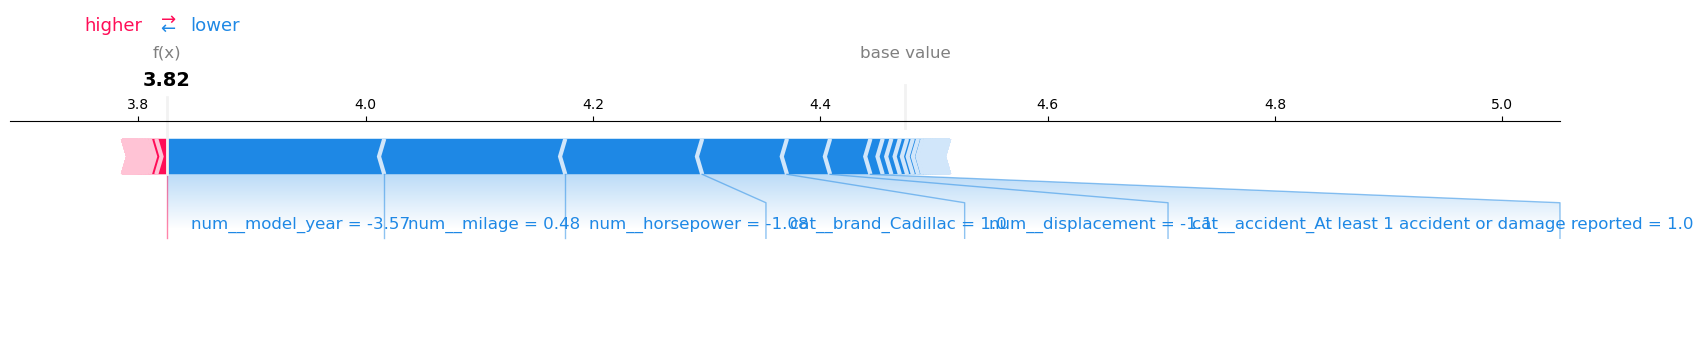

Saved SHAP force plot for index 766 to ../figures/force_plot_index_766.png


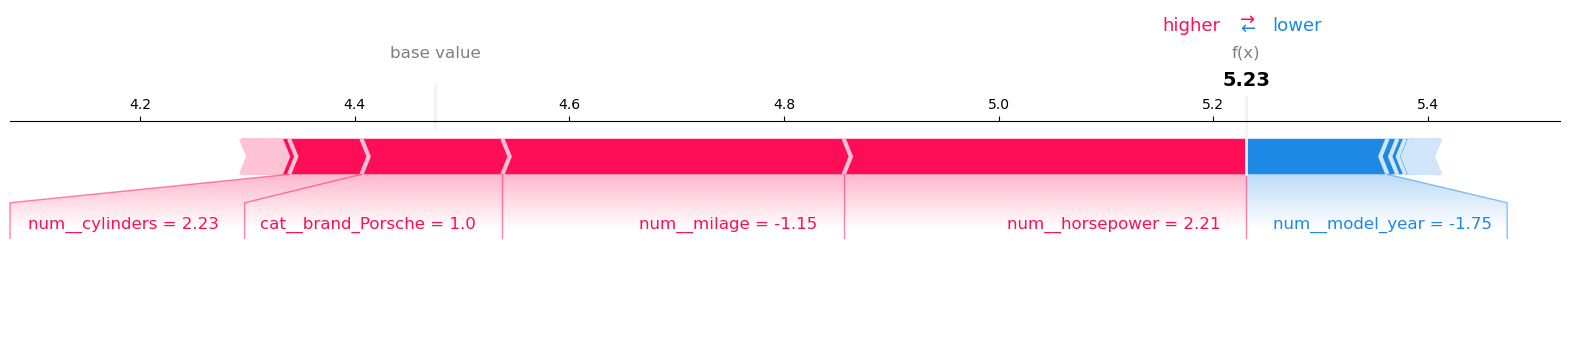

Saved SHAP force plot for index 493 to ../figures/force_plot_index_493.png


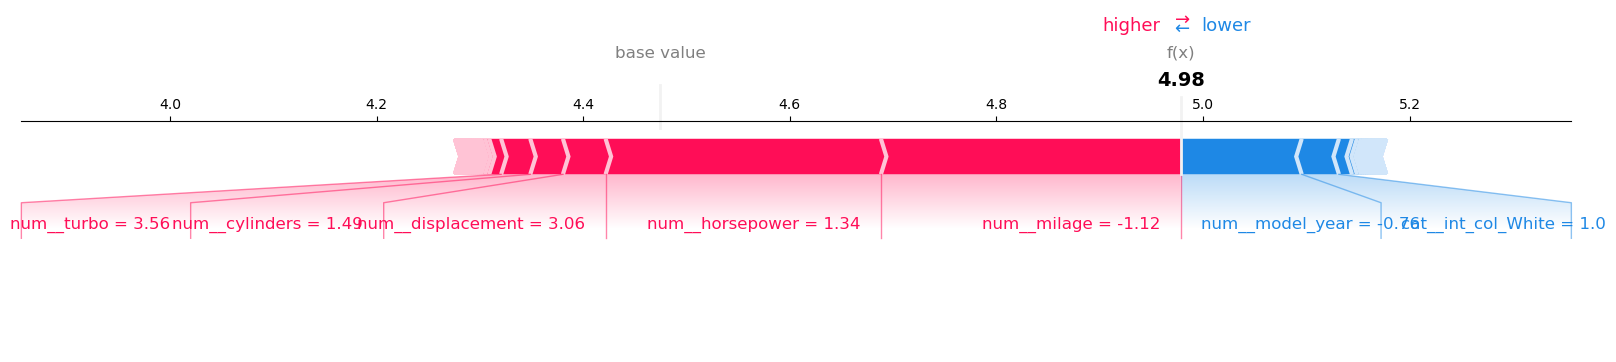

Saved SHAP force plot for index 165 to ../figures/force_plot_index_165.png


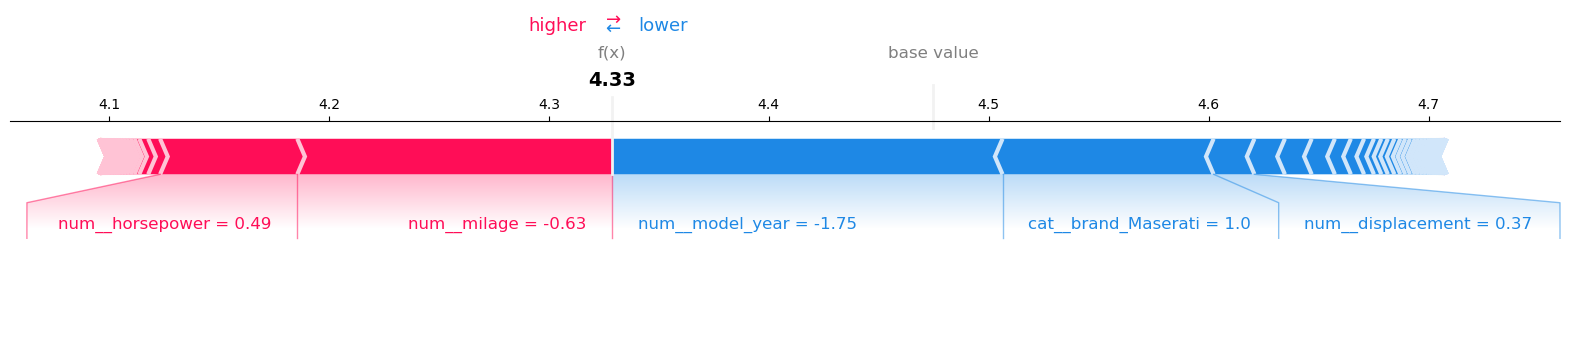

Saved SHAP force plot for index 70 to ../figures/force_plot_index_70.png


In [33]:
import os
import shap
import numpy as np
import matplotlib.pyplot as plt

# Initialize SHAP
shap.initjs()

# Create SHAP explainer for the model
explainer = shap.TreeExplainer(best_model)  # Replace best_model with your trained model

# Compute SHAP values for the test set
shap_values = explainer(X_test_imputed_xgb)  # Pass df_test, the feature matrix, NOT y_test

# Directory to save the plots
output_dir = "../figures"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Identify indices for top 3 and lowest 3 values in y_test
top_3_indices = np.argsort(y_test)[-3:]  # Indices for top 3 values
lowest_3_indices = np.argsort(y_test)[:3]  # Indices for lowest 3 values

# Combine top and lowest indices
selected_indices = np.concatenate((lowest_3_indices, top_3_indices))

# Loop through the selected indices to create and save plots
for index in selected_indices:
    # Ensure feature values are in the correct shape
    feature_values = X_test_imputed_xgb.iloc[index].values.round(2)  # Convert to 1D array
    
    # Generate SHAP force plot
    shap.force_plot(
        explainer.expected_value,
        shap_values[index].values,
        feature_values,
        feature_names=X_test_imputed_xgb.columns.tolist(),
        matplotlib=True
    )
    
    # Save the plot
    plt.title(f"SHAP Force Plot for Index {index}")
    filename = os.path.join(output_dir, f"force_plot_index_{index}.png")
    plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    plt.close()  # Close the plot to avoid overlapping
    print(f"Saved SHAP force plot for index {index} to {filename}")
